In [3]:
!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-1.10.0+cu113.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-1.10.0+cu113.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

In [4]:
import torch
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.datasets import Planetoid
import torch_geometric.transforms as T
import matplotlib.pyplot as plt

# **Cora Dataset**

In [5]:
from torch_geometric.nn import GATConv

name_data = 'Cora'
dataset = Planetoid(root= '/tmp/' + name_data, name = name_data)
dataset.transform = T.NormalizeFeatures()
print(f"Number of Classes in {name_data}:", dataset.num_classes)
print(f"Number of Node Features in {name_data}:", dataset.num_node_features)
data = dataset[0]

class Net(torch.nn.Module):
    def __init__(self, in_channels, out_channels,heads):
        super().__init__()

        self.conv1 = GATConv(in_channels, 8, heads=heads, dropout=0.6)
        # On the Pubmed dataset, use heads=8 in conv2.
        self.conv2 = GATConv(heads*8 , out_channels, heads=1, concat=False,
                             dropout=0.6)

    def forward(self, x, edge_index):
        x = F.dropout(x, p=0.6, training=self.training)
        x = F.elu(self.conv1(x, edge_index))
        x = F.dropout(x, p=0.6, training=self.training)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=-1)

Processing...


Number of Classes in Cora: 7
Number of Node Features in Cora: 1433


Done!


In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Net(dataset.num_features, dataset.num_classes,8).to(device)
data = data.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=5e-4)


def train(data):
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()


@torch.no_grad()
def test(data):
    model.eval()
    out, accs = model(data.x, data.edge_index), []
    for _, mask in data('train_mask', 'val_mask', 'test_mask'):
        acc = float((out[mask].argmax(-1) == data.y[mask]).sum() / mask.sum())
        accs.append(acc)
    return accs


for epoch in range(1, 201):
    train(data)
    train_acc, val_acc, test_acc = test(data)
    print(f'Epoch: {epoch:03d}, Train: {train_acc:.4f}, Val: {val_acc:.4f}, '
          f'Test: {test_acc:.4f}')

Epoch: 001, Train: 0.2357, Val: 0.1360, Test: 0.1620
Epoch: 002, Train: 0.2429, Val: 0.1280, Test: 0.1590
Epoch: 003, Train: 0.4500, Val: 0.2220, Test: 0.2840
Epoch: 004, Train: 0.6571, Val: 0.3820, Test: 0.3950
Epoch: 005, Train: 0.6571, Val: 0.3800, Test: 0.3890
Epoch: 006, Train: 0.6214, Val: 0.4080, Test: 0.4250
Epoch: 007, Train: 0.6857, Val: 0.4440, Test: 0.4680
Epoch: 008, Train: 0.7857, Val: 0.5820, Test: 0.5640
Epoch: 009, Train: 0.8571, Val: 0.6340, Test: 0.6280
Epoch: 010, Train: 0.8786, Val: 0.6580, Test: 0.6540
Epoch: 011, Train: 0.9000, Val: 0.6680, Test: 0.6720
Epoch: 012, Train: 0.9000, Val: 0.7060, Test: 0.6890
Epoch: 013, Train: 0.9000, Val: 0.7240, Test: 0.7080
Epoch: 014, Train: 0.9214, Val: 0.7480, Test: 0.7250
Epoch: 015, Train: 0.9214, Val: 0.7420, Test: 0.7310
Epoch: 016, Train: 0.9214, Val: 0.7440, Test: 0.7350
Epoch: 017, Train: 0.9214, Val: 0.7540, Test: 0.7470
Epoch: 018, Train: 0.9214, Val: 0.7520, Test: 0.7420
Epoch: 019, Train: 0.9286, Val: 0.7640, Test: 

In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
def make_model(dataset,num_heads):
  accuracies =[]
  train_accuracies = []

  data = dataset[0]
  for i in range(1,num_heads+1):
    model = Net(dataset.num_features, dataset.num_classes,i).to(device)
    data = data.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=5e-4)

    def train(data):
      model.train()
      optimizer.zero_grad()
      out = model(data.x, data.edge_index)
      loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
      loss.backward()
      optimizer.step()


    @torch.no_grad()
    def test(data):
        model.eval()
        out, accs = model(data.x, data.edge_index), []
        for _, mask in data('train_mask', 'val_mask', 'test_mask'):
            acc = float((out[mask].argmax(-1) == data.y[mask]).sum() / mask.sum())
            accs.append(acc)
        return accs


    for epoch in range(1, 201):
        train(data)
        train_acc, val_acc, test_acc = test(data)
        print(f'Epoch: {epoch:03d}, Train: {train_acc:.4f}, Val: {val_acc:.4f}, '
              f'Test: {test_acc:.4f}')
        if epoch == 200:
          accuracies.append(test_acc)
          train_accuracies.append(train_acc)
          print("***"*50+"iteration: "+ str(i)+"***"*50)
  return accuracies,train_accuracies 
        

### plot accuracy 


In [9]:
name_data = 'Cora'
dataset = Planetoid(root= '/tmp/' + name_data, name = name_data)
dataset.transform = T.NormalizeFeatures()
print(f"Number of Classes in {name_data}:", dataset.num_classes)
print(f"Number of Node Features in {name_data}:", dataset.num_node_features)
data = dataset[0]

cora_accuracies,cora_train_accuracies = make_model(dataset,20)

Number of Classes in Cora: 7
Number of Node Features in Cora: 1433
Epoch: 001, Train: 0.1571, Val: 0.0740, Test: 0.0760
Epoch: 002, Train: 0.2071, Val: 0.1220, Test: 0.1260
Epoch: 003, Train: 0.2429, Val: 0.1540, Test: 0.1570
Epoch: 004, Train: 0.3214, Val: 0.2340, Test: 0.2240
Epoch: 005, Train: 0.4571, Val: 0.4420, Test: 0.4360
Epoch: 006, Train: 0.5571, Val: 0.4940, Test: 0.4860
Epoch: 007, Train: 0.5000, Val: 0.4220, Test: 0.4190
Epoch: 008, Train: 0.3714, Val: 0.2940, Test: 0.3150
Epoch: 009, Train: 0.3214, Val: 0.2420, Test: 0.2530
Epoch: 010, Train: 0.3286, Val: 0.1960, Test: 0.2100
Epoch: 011, Train: 0.3143, Val: 0.2180, Test: 0.2190
Epoch: 012, Train: 0.3643, Val: 0.2440, Test: 0.2510
Epoch: 013, Train: 0.3714, Val: 0.2580, Test: 0.2600
Epoch: 014, Train: 0.3786, Val: 0.2560, Test: 0.2610
Epoch: 015, Train: 0.4071, Val: 0.2660, Test: 0.2630
Epoch: 016, Train: 0.4429, Val: 0.2780, Test: 0.2680
Epoch: 017, Train: 0.4714, Val: 0.2760, Test: 0.2860
Epoch: 018, Train: 0.5000, Val: 

In [10]:
cora_accuracies

[0.7789999842643738,
 0.8119999766349792,
 0.8019999861717224,
 0.8230000138282776,
 0.8259999752044678,
 0.8220000267028809,
 0.8009999990463257,
 0.8140000104904175,
 0.8199999928474426,
 0.8240000009536743,
 0.8190000057220459,
 0.8199999928474426,
 0.828000009059906,
 0.8240000009536743,
 0.8270000219345093,
 0.8190000057220459,
 0.8209999799728394,
 0.8309999704360962,
 0.8059999942779541,
 0.8130000233650208]

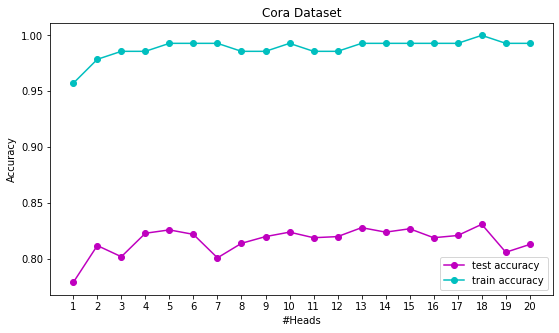

In [11]:
import numpy
plt.figure(figsize=(9,5))
plt.plot(range(1,21), cora_accuracies,'-o',c='m')
plt.plot(range(1,21), cora_train_accuracies,'-o',c='c')
plt.xticks(numpy.arange(1,21,1))
plt.title("Cora Dataset")
plt.xlabel('#Heads')
plt.ylabel('Accuracy')
plt.legend(['test accuracy', 'train accuracy'])

# **Citeseer Dataset**

In [15]:
name_data = 'Citeseer'
dataset = Planetoid(root= '/tmp/' + name_data, name = name_data)
dataset.transform = T.NormalizeFeatures()
print(f"Number of Classes in {name_data}:", dataset.num_classes)
print(f"Number of Node Features in {name_data}:", dataset.num_node_features)
data = dataset[0]

class Net(torch.nn.Module):
    def __init__(self, in_channels, out_channels,heads):
        super().__init__()

        self.conv1 = GATConv(in_channels, 8, heads=heads, dropout=0.6)
        # On the Pubmed dataset, use heads=8 in conv2.
        self.conv2 = GATConv(heads*8 , out_channels, heads=1, concat=False,
                             dropout=0.6)

    def forward(self, x, edge_index):
        x = F.dropout(x, p=0.6, training=self.training)
        x = F.elu(self.conv1(x, edge_index))
        x = F.dropout(x, p=0.6, training=self.training)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=-1)

Number of Classes in Citeseer: 6
Number of Node Features in Citeseer: 3703


In [17]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Net(dataset.num_features, dataset.num_classes,8).to(device)
data = data.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=5e-4)


def train(data):
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()


@torch.no_grad()
def test(data):
    model.eval()
    out, accs = model(data.x, data.edge_index), []
    for _, mask in data('train_mask', 'val_mask', 'test_mask'):
        acc = float((out[mask].argmax(-1) == data.y[mask]).sum() / mask.sum())
        accs.append(acc)
    return accs


for epoch in range(1, 201):
    train(data)
    train_acc, val_acc, test_acc = test(data)
    print(f'Epoch: {epoch:03d}, Train: {train_acc:.4f}, Val: {val_acc:.4f}, '
          f'Test: {test_acc:.4f}')

Epoch: 001, Train: 0.2333, Val: 0.2720, Test: 0.2180
Epoch: 002, Train: 0.4500, Val: 0.4080, Test: 0.3760
Epoch: 003, Train: 0.2167, Val: 0.2140, Test: 0.2350
Epoch: 004, Train: 0.1833, Val: 0.2140, Test: 0.2310
Epoch: 005, Train: 0.1917, Val: 0.2140, Test: 0.2320
Epoch: 006, Train: 0.2250, Val: 0.2140, Test: 0.2380
Epoch: 007, Train: 0.3667, Val: 0.2420, Test: 0.2670
Epoch: 008, Train: 0.5083, Val: 0.2980, Test: 0.3140
Epoch: 009, Train: 0.6583, Val: 0.3880, Test: 0.4190
Epoch: 010, Train: 0.8083, Val: 0.5240, Test: 0.5400
Epoch: 011, Train: 0.8917, Val: 0.6140, Test: 0.6170
Epoch: 012, Train: 0.9083, Val: 0.6360, Test: 0.6600
Epoch: 013, Train: 0.9083, Val: 0.6000, Test: 0.6430
Epoch: 014, Train: 0.9167, Val: 0.6080, Test: 0.6180
Epoch: 015, Train: 0.9083, Val: 0.6060, Test: 0.6280
Epoch: 016, Train: 0.9167, Val: 0.5920, Test: 0.6170
Epoch: 017, Train: 0.9250, Val: 0.5780, Test: 0.5940
Epoch: 018, Train: 0.9167, Val: 0.5960, Test: 0.5930
Epoch: 019, Train: 0.9333, Val: 0.6120, Test: 

### plot accuray

In [18]:
name_data = 'Citeseer'
dataset = Planetoid(root= '/tmp/' + name_data, name = name_data)
dataset.transform = T.NormalizeFeatures()
print(f"Number of Classes in {name_data}:", dataset.num_classes)
print(f"Number of Node Features in {name_data}:", dataset.num_node_features)
data = dataset[0]

citeseer_accuracies,citeseer_train_accuracies = make_model(dataset,20)

Number of Classes in Citeseer: 6
Number of Node Features in Citeseer: 3703
Epoch: 001, Train: 0.2417, Val: 0.1160, Test: 0.1300
Epoch: 002, Train: 0.2750, Val: 0.1480, Test: 0.1600
Epoch: 003, Train: 0.4250, Val: 0.2500, Test: 0.2460
Epoch: 004, Train: 0.4750, Val: 0.3800, Test: 0.3630
Epoch: 005, Train: 0.6167, Val: 0.4920, Test: 0.5180
Epoch: 006, Train: 0.5417, Val: 0.3920, Test: 0.3980
Epoch: 007, Train: 0.5083, Val: 0.3780, Test: 0.3840
Epoch: 008, Train: 0.6500, Val: 0.4780, Test: 0.4820
Epoch: 009, Train: 0.7750, Val: 0.5180, Test: 0.5410
Epoch: 010, Train: 0.7667, Val: 0.5060, Test: 0.5410
Epoch: 011, Train: 0.7750, Val: 0.5140, Test: 0.5450
Epoch: 012, Train: 0.8083, Val: 0.5100, Test: 0.5170
Epoch: 013, Train: 0.8083, Val: 0.5000, Test: 0.5060
Epoch: 014, Train: 0.8167, Val: 0.4380, Test: 0.4700
Epoch: 015, Train: 0.8167, Val: 0.4560, Test: 0.4920
Epoch: 016, Train: 0.8333, Val: 0.5120, Test: 0.5440
Epoch: 017, Train: 0.8417, Val: 0.5320, Test: 0.5690
Epoch: 018, Train: 0.825

In [ ]:
citeseer_accuracies

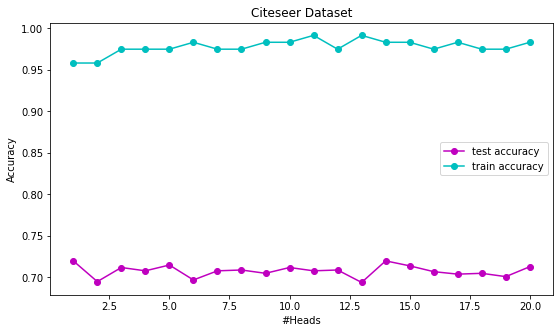

In [ ]:
plt.figure(figsize=(9,5))
plt.plot(range(1,21), citeseer_accuracies,'-o',c='m')
plt.plot( range(1,21), citeseer_train_accuracies,'-o',c='c')
plt.title("Citeseer Dataset")
plt.xlabel('#Heads')
plt.ylabel('Accuracy')
plt.legend(['test accuracy', 'train accuracy'])

# **Pubmed Dataset**

In [ ]:
name_data = 'Pubmed'
dataset = Planetoid(root= '/tmp/' + name_data, name = name_data)
dataset.transform = T.NormalizeFeatures()
print(f"Number of Classes in {name_data}:", dataset.num_classes)
print(f"Number of Node Features in {name_data}:", dataset.num_node_features)
data = dataset[0]

class Net(torch.nn.Module):
    def __init__(self, in_channels, out_channels,heads):
        super().__init__()

        self.conv1 = GATConv(in_channels, 8, heads=heads, dropout=0.6)
        # On the Pubmed dataset, use heads=8 in conv2.
        self.conv2 = GATConv(8 * heads, out_channels, heads=8, concat=True,
                             dropout=0.6)

    def forward(self, x, edge_index):
        x = F.dropout(x, p=0.6, training=self.training)
        x = F.elu(self.conv1(x, edge_index))
        x = F.dropout(x, p=0.6, training=self.training)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=-1)

Processing...


Number of Classes in Pubmed: 3
Number of Node Features in Pubmed: 500


Done!


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Net(dataset.num_features, dataset.num_classes).to(device)
data = data.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=1e-3)


def train(data):
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()


@torch.no_grad()
def test(data):
    model.eval()
    out, accs = model(data.x, data.edge_index), []
    for _, mask in data('train_mask', 'val_mask', 'test_mask'):
        acc = float((out[mask].argmax(-1) == data.y[mask]).sum() / mask.sum())
        accs.append(acc)
    return accs


for epoch in range(1, 201):
    train(data)
    train_acc, val_acc, test_acc = test(data)
    print(f'Epoch: {epoch:03d}, Train: {train_acc:.4f}, Val: {val_acc:.4f}, '
          f'Test: {test_acc:.4f}')

TypeError: ignored

In [ ]:
Pubmed_accuracies,Pubmed_train_accuracies = make_model(dataset,20)

Epoch: 001, Train: 0.4500, Val: 0.4320, Test: 0.4320
Epoch: 002, Train: 0.3500, Val: 0.3920, Test: 0.4180
Epoch: 003, Train: 0.3333, Val: 0.3900, Test: 0.4130
Epoch: 004, Train: 0.3333, Val: 0.3880, Test: 0.4130
Epoch: 005, Train: 0.3333, Val: 0.3880, Test: 0.4130
Epoch: 006, Train: 0.3333, Val: 0.3880, Test: 0.4130
Epoch: 007, Train: 0.3333, Val: 0.3880, Test: 0.4130
Epoch: 008, Train: 0.3333, Val: 0.3880, Test: 0.4130
Epoch: 009, Train: 0.3333, Val: 0.3880, Test: 0.4130
Epoch: 010, Train: 0.3333, Val: 0.3880, Test: 0.4130
Epoch: 011, Train: 0.3333, Val: 0.3880, Test: 0.4130
Epoch: 012, Train: 0.3333, Val: 0.3880, Test: 0.4130
Epoch: 013, Train: 0.3333, Val: 0.3880, Test: 0.4130
Epoch: 014, Train: 0.3333, Val: 0.3880, Test: 0.4130
Epoch: 015, Train: 0.3333, Val: 0.3880, Test: 0.4130
Epoch: 016, Train: 0.3333, Val: 0.3880, Test: 0.4130
Epoch: 017, Train: 0.3333, Val: 0.3880, Test: 0.4130
Epoch: 018, Train: 0.3333, Val: 0.3880, Test: 0.4130
Epoch: 019, Train: 0.3333, Val: 0.3880, Test: 

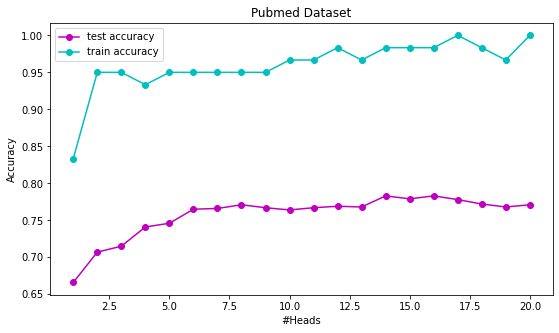

In [ ]:
plt.figure(figsize=(9,5))
plt.plot(range(1,21), Pubmed_accuracies,'-o',c='m')
plt.plot( range(1,21), Pubmed_train_accuracies,'-o',c='c')

plt.title('Pubmed Dataset')
plt.xlabel('#Heads')
plt.ylabel('Accuracy')
plt.legend(['test accuracy', 'train accuracy'])